<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [Lightcurves](04.00-Lightcurves.ipynb) | [Contents](Index.ipynb) | [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) >

# Phase-folded time-series variability plots

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [3]:
import pandas as pd

In [4]:
import sys
import os

In [5]:
sys.path.append(os.path.abspath("../code/"))

In [6]:
from xphotometryx import seasonal_aggregation
from xphotometryx import master_photometry

/Users/obsidian/anaconda3/envs/xveganx/lib/python3.6/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "


In [7]:
master_all = master_photometry()

Demo of seasonal aggregation:

In [8]:
import lightkurve

In [9]:
tpf = lightkurve.KeplerTargetPixelFile.from_archive(210662824, campaign=4)

In [10]:
tpf.interact(notebook_url='http://localhost:8889')

In [11]:
tpf2 = lightkurve.KeplerTargetPixelFile.from_archive(210662824, campaign=13)

In [12]:
tpf2.interact(notebook_url='http://localhost:8889')

In [135]:
lc = tpf.to_lightcurve()
lc2 = tpf2.to_lightcurve()

In [94]:
pg = lc.to_periodogram(period=np.arange(2.0, 3.0, 0.0001))

You have passed an evenly-spaced grid of periods. These are not evenly spaced in frequency space.
Method has been set to 'slow' to allow for this.
Method has been set to 'slow' to allow for this.


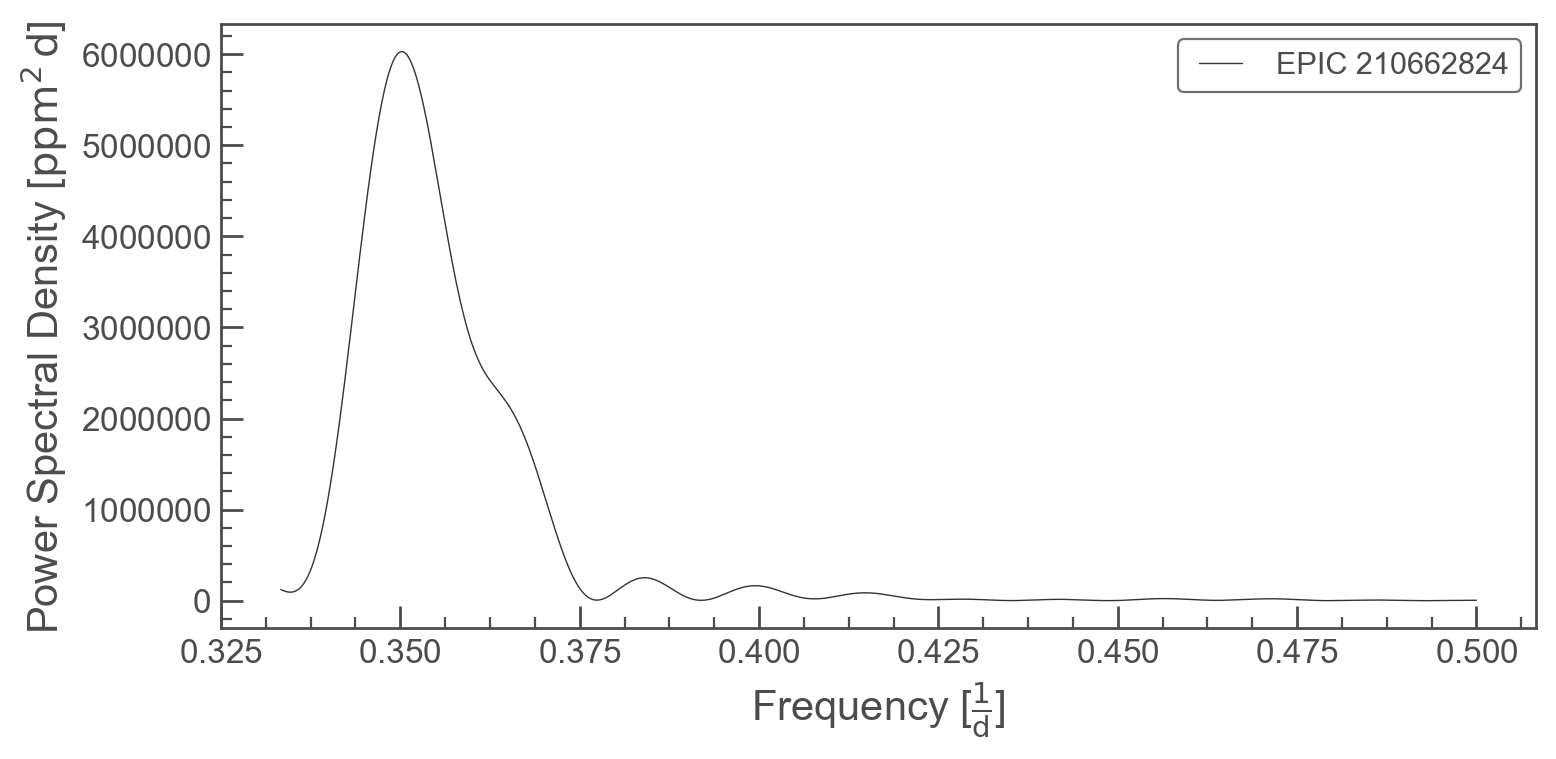

In [95]:
pg.plot()

In [96]:
pg.period_at_max_power

<Quantity 2.8555 d>

In [13]:
master = master_all[master_all.object == 'TAP 35']
seasonal_agg = seasonal_aggregation(master, 'TAP 35')

## Metadata for observing "epochs"

In [15]:
epochs = pd.read_csv('../data/metadata/IGRINS_hdr_table.csv', usecols=['OBJECT', 'ACQTIME'])

In [16]:
epochs = epochs.rename(columns={'ACQTIME':'JD_like'})

In [17]:
gb = master_all.groupby('object')

In [18]:
n_seasons = gb.season.nunique().reset_index()

In [19]:
n_seasons

,object,season
0,Anon 1,11
1,HD 283572,18
2,Hubble 4,6
3,LkCa 1,10
4,LkCa 14,8
5,LkCa 16,8
6,LkCa 19,17
7,LkCa 4,18
8,LkCa 7,20
9,TAP 35,14


In [20]:
IGRINS_to_Grankin = {'Anon1':'Anon 1', 'HD283572': 'HD 283572', 'Hubble_4':'Hubble 4',
                    'IW Tau':'LkCa 16', 'IW Tau A':'LkCa 16', 'L1551-55':'TAP 45',
                    'LkCa 4 A':'LkCa 4', 'LkCa14':'LkCa 14', 'V 1070 Tau':'LkCa 7', 'V819Tau':'V819 Tau',
                    'V827Tau':'V827 Tau','V836Tau':'V836 Tau', 'L1551 IRS 5':None, 'HBC 388': 'TAP 35'}

In [21]:
epochs['Grankin_name'] = epochs.OBJECT.replace(IGRINS_to_Grankin)

Drop `L1551 IRS 5`, it's not in the Grankin sample.

In [22]:
epochs = epochs[epochs.OBJECT !='L1551 IRS 5'].reset_index(drop=True)

In [23]:
epochs.groupby('Grankin_name').count()['OBJECT'].to_frame(name='n_epochs').reset_index()

,Grankin_name,n_epochs
0,Anon 1,1
1,HD 283572,3
2,Hubble 4,1
3,LkCa 1,1
4,LkCa 14,1
5,LkCa 16,2
6,LkCa 19,2
7,LkCa 4,2
8,LkCa 7,1
9,TAP 35,1


Neat-- Some Objects have multiple IGRINS epochs available.
We'll want to group by object first, then by season.

In [24]:
epochs['Observation'] = 'IGRINS'
epochs['Instrument'] = 'IGRINS'

Associate each epoch with the closest season

In [25]:
epochs['InSeason'] = np.NaN
epochs['NearSeason'] = np.NaN
epochs['dist_hi'] = np.NaN
epochs['dist_lo'] = np.NaN
epochs['season_hi'] = np.NaN
epochs['season_lo'] = np.NaN

Assign seasons or nearby seasons to IGRINS epochs:

In [26]:
for i in range(len(epochs)):
    name = epochs.Grankin_name[i]
    master = master_all[master_all.object == name]
    season_agg = seasonal_aggregation(master, name)
    sid = ((season_agg.JD_min < epochs.JD_like[i]) & 
           (season_agg.JD_max > epochs.JD_like[i]) &
           (name == epochs.Grankin_name[i]))
    if sid.sum()==1:
        epochs.InSeason[i] = season_agg.season[sid]
    else:
        dist_lo = np.abs(epochs.JD_like[i]-season_agg.JD_min)
        dist_hi = np.abs(epochs.JD_like[i]-season_agg.JD_max) 
        s_hi = np.argmin(dist_hi)
        s_lo = s_hi+1
        epochs.season_hi[i] = season_agg.season[s_hi]
        epochs.season_lo[i] = season_agg.season[s_lo]
        epochs.dist_hi[i] = np.ceil(dist_hi[s_hi])
        epochs.dist_lo[i] = np.ceil(dist_lo[s_lo])

In [27]:
epochs

,JD_like,OBJECT,Grankin_name,Observation,Instrument,InSeason,NearSeason,dist_hi,dist_lo,season_hi,season_lo
0,2.456981e+06,Anon1,Anon 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
1,2.456982e+06,HD283572,HD 283572,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
2,2.456983e+06,V827Tau,V827 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
3,2.456983e+06,Hubble_4,Hubble 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
4,2.456985e+06,IW Tau A,LkCa 16,IGRINS,IGRINS,NaN,NaN,118.0,243.0,30.0,31.0
5,2.456988e+06,LkCa 19,LkCa 19,IGRINS,IGRINS,NaN,NaN,115.0,240.0,30.0,31.0
6,2.456990e+06,LkCa 1,LkCa 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
7,2.456991e+06,V826 Tau,V826 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
8,2.456991e+06,HBC 388,TAP 35,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
9,2.456991e+06,LkCa 4 A,LkCa 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN


The IGRINS observations that were not contemporaneous with a photometric season were all ~100 days after the end of the season.  Not great, but we don't have a better solution.

In [28]:
epochs.NearSeason = epochs.season_hi

In [29]:
epochs['AdoptedSeason'] = epochs.InSeason
out_of_season = epochs.InSeason != epochs.InSeason
epochs.AdoptedSeason[out_of_season] = epochs.NearSeason[out_of_season]

Placeholders for BVR magnitude estimates:

In [30]:
epochs['B_est'], epochs['V_est'], epochs['R_est'] = 0.0, 0.0, 0.0

In [31]:
epochs['JD-2450000'] = epochs.JD_like-2450000.0

We don't want to label everything we know about:

In [32]:
epochs

,JD_like,OBJECT,Grankin_name,Observation,Instrument,InSeason,NearSeason,dist_hi,dist_lo,season_hi,season_lo,AdoptedSeason,B_est,V_est,R_est,JD-2450000
0,2.456981e+06,Anon1,Anon 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6980.889063
1,2.456982e+06,HD283572,HD 283572,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6981.861100
2,2.456983e+06,V827Tau,V827 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6982.724769
3,2.456983e+06,Hubble_4,Hubble 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6982.830000
4,2.456985e+06,IW Tau A,LkCa 16,IGRINS,IGRINS,NaN,30.0,118.0,243.0,30.0,31.0,30.0,0.0,0.0,0.0,6984.844769
5,2.456988e+06,LkCa 19,LkCa 19,IGRINS,IGRINS,NaN,30.0,115.0,240.0,30.0,31.0,30.0,0.0,0.0,0.0,6987.927338
6,2.456990e+06,LkCa 1,LkCa 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6989.869491
7,2.456991e+06,V826 Tau,V826 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6990.709491
8,2.456991e+06,HBC 388,TAP 35,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6990.763368
9,2.456991e+06,LkCa 4 A,LkCa 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6990.790382


Lo and behold, all observations are in or near Season 30!

In [33]:
epochs = epochs.reset_index(drop=True)

In [34]:
epoch_ls = pd.DataFrame(columns=['Instrument', 'color', 'linestyles'])

epoch_ls = epoch_ls.append({"Instrument":'IGRINS', "color":'red', 'linestyles':'solid'}, ignore_index=True)

In [35]:
epochs_orig = epochs.copy()

In [36]:
epochs = pd.merge(epochs, epoch_ls, on='Instrument')

In [37]:
for i, (name, group) in enumerate(gb):
    print(i, name)

0 Anon 1
1 HD 283572
2 Hubble 4
3 LkCa 1
4 LkCa 14
5 LkCa 16
6 LkCa 19
7 LkCa 4
8 LkCa 7
9 TAP 35
10 TAP 41
11 TAP 45
12 V819 Tau
13 V826 Tau
14 V827 Tau
15 V836 Tau


## Lightcurve analysis

In [38]:
from xphotometryx import *

In [39]:
master_30 = master_all[master_all.season == 30].reset_index(drop=True)

In [40]:
def plot_stamps_season30(master_30, epochs, ylim=(13.7, 13.3), savefig_file='../results/test_by_objs.pdf', ylabel='$V$'):
    '''
    Plots all the available seasons of photometry in phase-folded postage stamps.
    '''
    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(hspace=0.2, bottom=0.06, top=0.94, left=0.12, right=0.94)
    n_stamps = len(epochs.Grankin_name.unique())
    
    gb = epochs[['Grankin_name', 'JD_like']].groupby('Grankin_name')
    

    for i, (name, group) in enumerate(gb):
        print(i, name)
        # get the data and best-fit angular frequency
        master = master_30[master_30.object == name]
        season_agg = seasonal_aggregation(master, name)
        s = 30
        df = master
        t = df.JD_like.values
        y = df.Vmag.values
        dy = df.Verr.values
        #this_P = season_agg.P_est1[i]
        this_P = season_agg.P_est1.median()
        if this_P!=this_P:
            this_P = 9000.25
        phased_t = np.mod(t, this_P)/this_P

        # Fit a multiterm model
        Nterms = 4
        reg = 0.1 * np.ones(2 * Nterms + 1)
        reg[:5] = 0 # no regularization on low-order terms
        if (df.year.min() == 2006):
            #TODO: change this to something sensible
            reg = 0.3 * np.ones(2 * Nterms + 1)
            reg[:3] = 0 # no regularization on low-order terms

        modelV = LombScargle(Nterms=4, regularization=reg)
        mask = y == y # We can mask flares later on
        modelV.fit(t[mask], y[mask], dy[mask])
        tfit = np.linspace(0, this_P, 100)
        yfitV = modelV.predict(tfit, period=this_P)


        # plot the phased data
        ax = fig.add_subplot(4,4,1 + i)
        plt.plot(tfit/this_P, yfitV, alpha=0.5)
        ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                    lw=1, ms=4, capsize=1.5)

        #---Mark observation epochs---
        ts_ids = group.JD_like == group.JD_like
        if ts_ids.sum() > 0:
            for ei in group.index.values[ts_ids.values]:
                this_phase = np.mod(group.JD_like[ei], this_P)/this_P
                ax.vlines(this_phase, 20.3, 5.2, linestyles='solid',
                          colors='red', alpha=0.8)
                for band, model in [('V_est', modelV)]:
                    try:
                        estimated_mag = model.predict(this_phase*this_P, period=this_P).tolist()
                        #epochs.set_value(ei, band, estimated_mag)
                        print(estimated_mag)
                    except:
                        pass
                        #print('{}: Band {} could not be computed'.format(group.Observation[ei], band))
        #-----------------------------

        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.set_ylim(master.Vmag.max(), master.Vmag.min())

        ax.text(0.03, 0.96, "{}".format(name),ha='left', va='top',
                transform=ax.transAxes)

        #if i < 18 :
        #    ax.xaxis.set_major_formatter(plt.NullFormatter())
        #if i % 4 != 0:
        #    ax.yaxis.set_major_formatter(plt.NullFormatter())
        if i % 4 == 0:
            ax.set_ylabel(ylabel)

        #if i in (18, 19, 20, 21):
        #    ax.set_xlabel('phase')

    plt.savefig(savefig_file, bbox_inches='tight')


0 Anon 1
13.522679996857066
1 HD 283572
8.99741785845538
9.014884950272544
9.022240999017654
2 Hubble 4
12.614546150293094
3 LkCa 1
13.763124638997569
4 LkCa 14
11.768556460579276
5 LkCa 16
13.008200147441615
12.75630314370713
6 LkCa 19
10.644256226878541
10.666672475212128
7 LkCa 4
12.733396693759733
12.77576108833416
8 LkCa 7
12.306565106112412
9 TAP 35
10.118211663978649
10 TAP 45
13.170887420472466
11 V819 Tau
12.867391239653125
12 V826 Tau
11.792814825367682
11.786443367288452
13 V827 Tau
12.899427275503102
14 V836 Tau
13.581038525978473


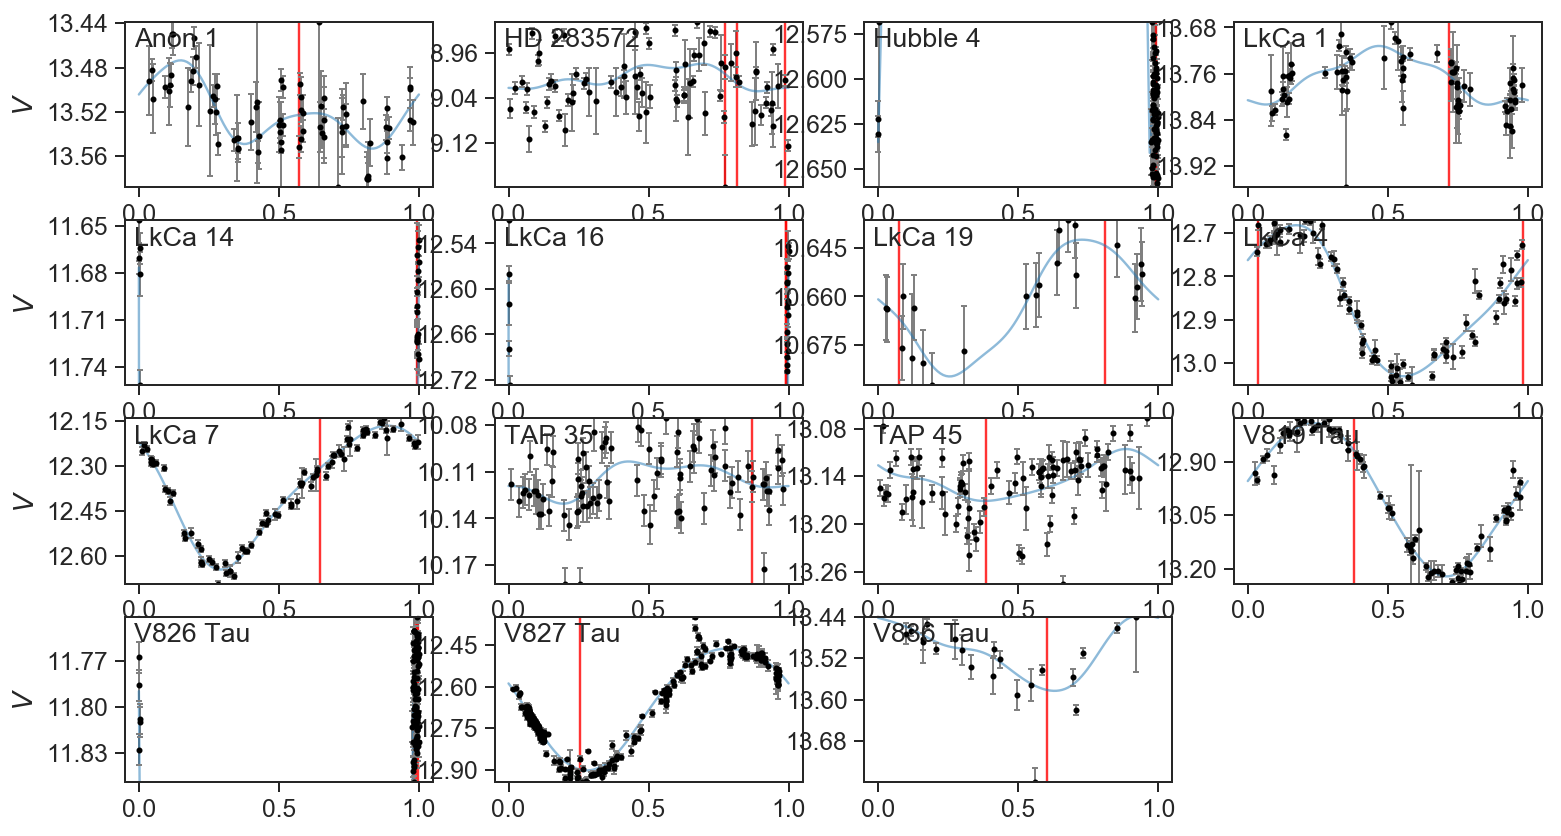

In [41]:
plot_stamps_season30(master_30, epochs)

Ew! This crummy figure needs some work...

Much better to plot the same object over time with the same scale:

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [98]:
master = master_all[master_all.object == 'TAP 35']
seasonal_agg = seasonal_aggregation(master, 'TAP 35')
seasonal_agg.P_est1 = 2.8555

In [99]:
seasonal_agg

,season,N_U,N_B,N_V,N_R,JD_min,JD_max,length,years,P_est1,P_err1
0,8,2,32,32,32,2.448860e+06,2.448956e+06,96.0,8/1992-11/1992,2.8555,0.1
1,9,2,46,46,46,2.449203e+06,2.449287e+06,84.0,8/1993-10/1993,2.8555,0.1
2,10,5,26,26,26,2.449584e+06,2.449697e+06,113.0,8/1994-12/1994,2.8555,0.1
3,11,8,32,32,32,2.449938e+06,2.449987e+06,49.0,8/1995-9/1995,2.8555,0.1
4,12,0,20,20,20,2.450366e+06,2.450415e+06,49.0,10/1996-11/1996,2.8555,0.1
5,13,0,25,25,25,2.450711e+06,2.450760e+06,50.0,9/1997-11/1997,2.8555,0.1
6,19,3,18,19,18,2.452884e+06,2.452924e+06,40.0,9/2003-10/2003,2.8555,0.1
7,20,0,26,26,26,2.453260e+06,2.453300e+06,40.0,9/2004-10/2004,2.8555,0.1
8,28,0,0,19,0,2.456196e+06,2.456338e+06,142.0,9/2012-2/2013,2.8555,0.1
9,29,0,0,41,0,2.456490e+06,2.456736e+06,246.0,7/2013-3/2014,2.8555,0.1


In [100]:
master.tail()

,JD_like,year,month,day,season,Vmag,Verr,Bmag,Berr,Rmag,Rerr,Umag,Uerr,source,date_type,object
4247,2.457834e+06,2017,3,21.028630,32,10.085000,0.014731,NaN,NaN,NaN,NaN,NaN,NaN,ASASSN,HJD,TAP 35
4248,2.457834e+06,2017,3,21.985950,32,10.085667,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,ASASSN,HJD,TAP 35
4249,2.457835e+06,2017,3,22.985013,32,10.110667,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,ASASSN,HJD,TAP 35
4250,2.457965e+06,2017,7,30.609540,33,10.082667,0.013204,NaN,NaN,NaN,NaN,NaN,NaN,ASASSN,HJD,TAP 35
4251,2.457969e+06,2017,8,3.423753,33,10.071667,0.010000,NaN,NaN,NaN,NaN,NaN,NaN,ASASSN,HJD,TAP 35


In [101]:
master = master.reset_index(drop=True)

In [102]:
epoch = epochs[epochs.Grankin_name =='TAP 35']

In [103]:
master.season.unique()

array([ 8,  9, 10, 11, 12, 13, 19, 20, 28, 29, 30, 31, 32, 33])

In [104]:
master[master.season==14]

,JD_like,year,month,day,season,Vmag,Verr,Bmag,Berr,Rmag,Rerr,Umag,Uerr,source,date_type,object


In [105]:
master.describe()

,JD_like,year,month,day,season,Vmag,Verr,Bmag,Berr,Rmag,Rerr,Umag,Uerr
count,5.340000e+02,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000,225.000000,225.00,225.000000,225.00,20.000000,20.00
mean,2.454298e+06,2006.904494,8.091760,16.765478,22.713483,10.186192,0.011238,11.048947,0.01,9.610396,0.01,11.377000,0.05
std,3.514497e+03,9.710068,3.308555,8.827852,9.539605,0.088881,0.011648,0.063727,0.00,0.054022,0.00,0.065213,0.00
min,2.448860e+06,1992.000000,1.000000,1.115880,8.000000,9.997000,0.010000,10.902000,0.01,9.500000,0.01,11.277000,0.05
25%,2.449978e+06,1995.000000,8.000000,9.411689,11.000000,10.114542,0.010000,10.999000,0.01,9.568000,0.01,11.330500,0.05
50%,2.456572e+06,2013.000000,9.000000,16.598878,29.000000,10.144000,0.010000,11.052000,0.01,9.615000,0.01,11.364000,0.05
75%,2.457334e+06,2015.000000,10.000000,24.890500,31.000000,10.261250,0.010000,11.095000,0.01,9.652000,0.01,11.395750,0.05
max,2.457969e+06,2017.000000,12.000000,31.928400,33.000000,10.446000,0.200076,11.234000,0.01,9.750000,0.01,11.525000,0.05


8
9
10
11
12
13
14
15
16
17
18
19
20
29
30
31
32
33


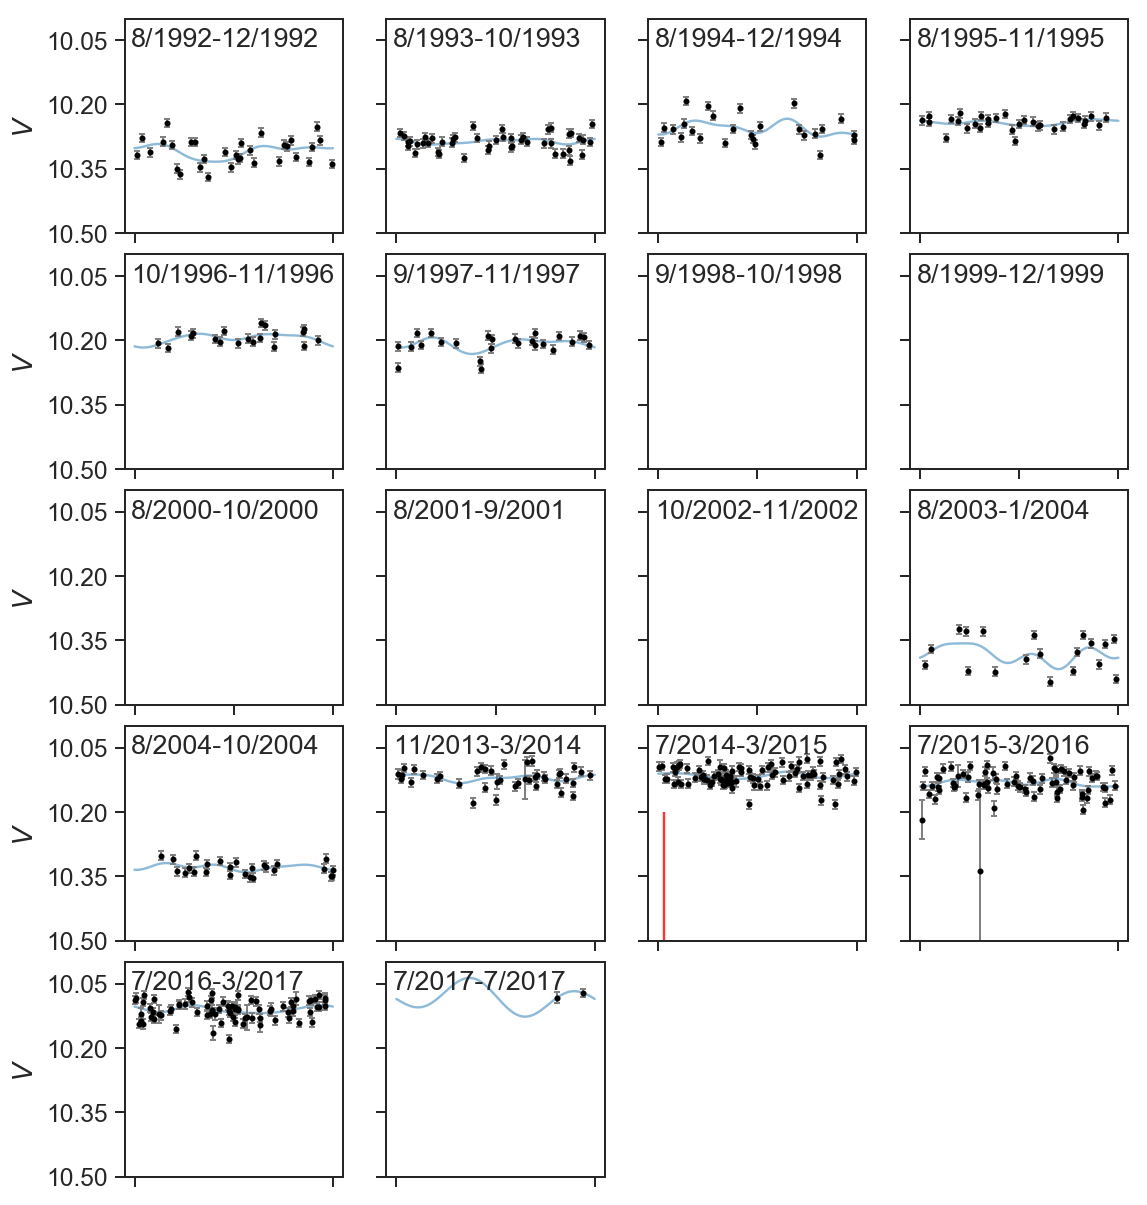

In [106]:
plot_season_postage_stamps(master, season_agg, epoch, ylim=(10.5, 10.0), 
                           savefig_file='../results/test_V.pdf', ylabel='$V$')

In [110]:
tpf.astropy_time.isot

array(['2015-02-08T07:12:57.652', '2015-02-08T07:42:23.033',
       '2015-02-08T08:11:48.405', ..., '2015-04-20T03:18:32.672',
       '2015-04-20T03:47:57.954', '2015-04-20T04:17:23.254'], dtype='<U23')

In [113]:
epoch.JD_like.values

array([2456990.76336806])

In [65]:
#plot_season_postage_stamps(master, season_agg, epochs, ylim=(15.2, 14.1), savefig_file='../results/test_B.pdf', ylabel='$B$')

In [114]:
import xphotometryx

In [115]:
xphotometryx.jd_to_date([2456990.76336806])

(array([2014]), array([11]), array([29.26336806]))

## Summarize estimated photometry into a table

Drop the Observations that we are not using: Nguyen, IGRINS_1.  
Drop the columns we are not using (most columns).  
Add a column for JD-2456000 to match Donati et al. 2014.

In [53]:
eps = epochs.copy()

keep = ['JD-2450000','Instrument', 'B_est', 'V_est', 'R_est']
discard = set(eps.columns.values) - set(keep)
eps.drop(list(discard), axis=1, inplace=True)
eps.replace(0.0, np.NaN, inplace=True)
eps[keep]

,JD-2450000,Instrument,B_est,V_est,R_est
0,6980.889063,IGRINS,NaN,10.109653,NaN
1,6981.861100,IGRINS,NaN,10.122732,NaN
2,6982.724769,IGRINS,NaN,10.105819,NaN
3,6982.830000,IGRINS,NaN,10.106327,NaN
4,6984.844769,IGRINS,NaN,10.119399,NaN
5,6987.927338,IGRINS,NaN,10.113537,NaN
6,6989.869491,IGRINS,NaN,10.115553,NaN
7,6990.709491,IGRINS,NaN,10.110163,NaN
8,6990.763368,IGRINS,NaN,10.109648,NaN
9,6990.790382,IGRINS,NaN,10.109467,NaN


## Full range of data

Photometric sources:

In [54]:
master.source.unique()

array(['Grankin et al. 2008', 'ASASSN'], dtype=object)

In [55]:
#sources = ['Vrba et al. 1993', 'Bouvier et al. 1993','Grankin et al. 2008', 'ASAS3',
#           'Integral-OMC','Donati et al. 2014','ASASSN','AAVSO', 'Grankin unpublished']
sources = ['Grankin et al. 2008', 'ASASSN']

In [56]:
fmts = ['s', '.']

Text(0.5, 0, 'JD')

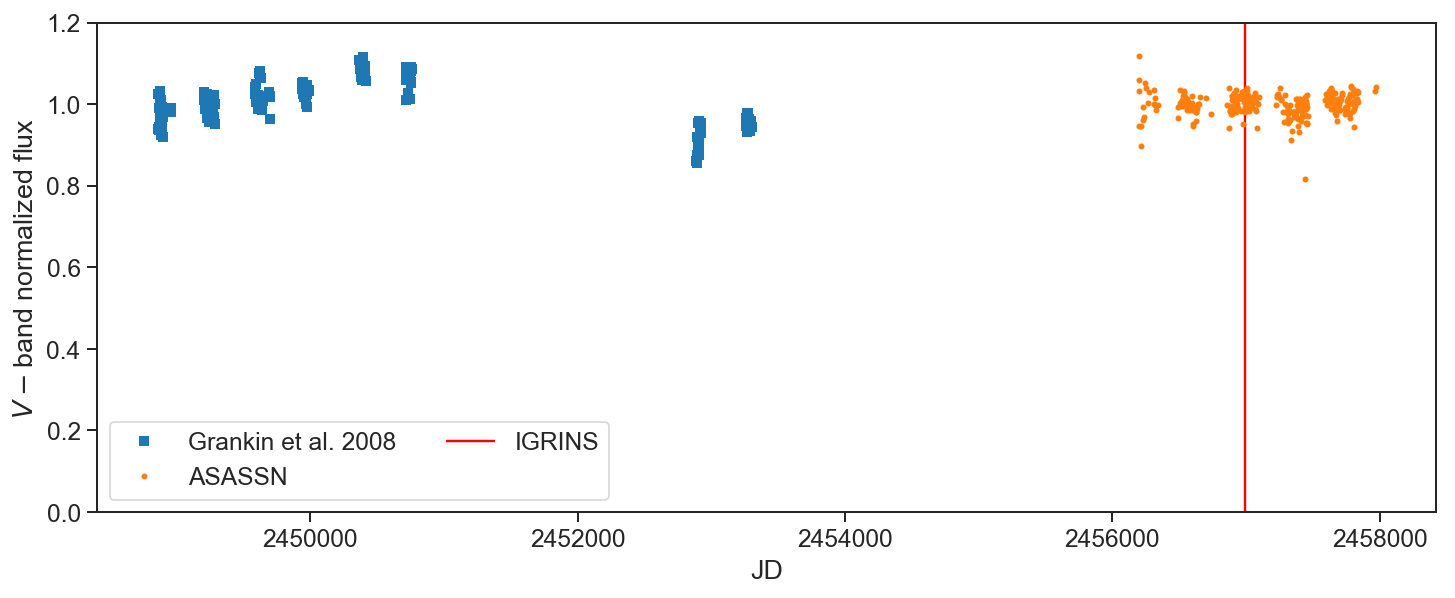

In [160]:
plt.figure(figsize=(12, 4.5))

for source, fmt in zip(sources, fmts):
    inds = master.source == source
    flux = 10**(-master.Vmag[inds]/2.5)
    flux_norm = flux/np.nanmedian(flux)
    plt.plot(master.JD_like[inds], flux_norm, fmt, ms=4,label=source)

for i in range(len(epochs)):
    if epochs.Grankin_name[i] == 'TAP 35':
        label = epochs.Instrument[i]
        plt.vlines(epochs.JD_like[i], 0, 2, colors=epochs.color[i], 
                   linestyles=epochs.linestyles[i], label = label)
    
#plt.vlines(2446192.083333, 13.5, 12.2, colors='cyan', linestyles='dashed')

legend = plt.legend(loc='bottom left', ncol=2)#, frameon=True, shadow=False, )

plt.ylim(0, 1.2)

plt.ylabel('$V-$band normalized flux ')
plt.xlabel('JD')

#plt.xlim(2446192.083333, 2457597.833333)
#plt.savefig('../results/V819_phot1986-2017.pdf', bbox_inches='tight')

In [190]:
df_new = pd.read_csv('../data/ASASSN/TAP35_ASASSN_20181121.csv')

In [191]:
df_new.head()

,HJD,UT Date,Camera,FWHM,Limit,mag,mag_err,flux(mJy),flux_err,Filter
0,2.455950e+06,2012-01-23.3878583,bb,2.32,99.990,99.990,99.990,99.990,99.990,V
1,2.455956e+06,2012-01-29.2837392,bb,2.34,99.990,99.990,99.990,99.990,99.990,V
2,2.455956e+06,2012-01-29.2853640,bb,2.35,99.990,99.990,99.990,99.990,99.990,V
3,2.455970e+06,2012-02-12.3194283,bb,2.13,15.281,10.244,0.003,306.201,0.932,V
4,2.455970e+06,2012-02-12.3212340,bb,2.13,15.287,10.258,0.003,302.333,0.881,V


In [192]:
df_new['norm_flux'] = df_new['flux(mJy)']/np.nanmedian(df_new['flux(mJy)'])

In [193]:
#df_new = df_new[df_new.HJD >2457900]

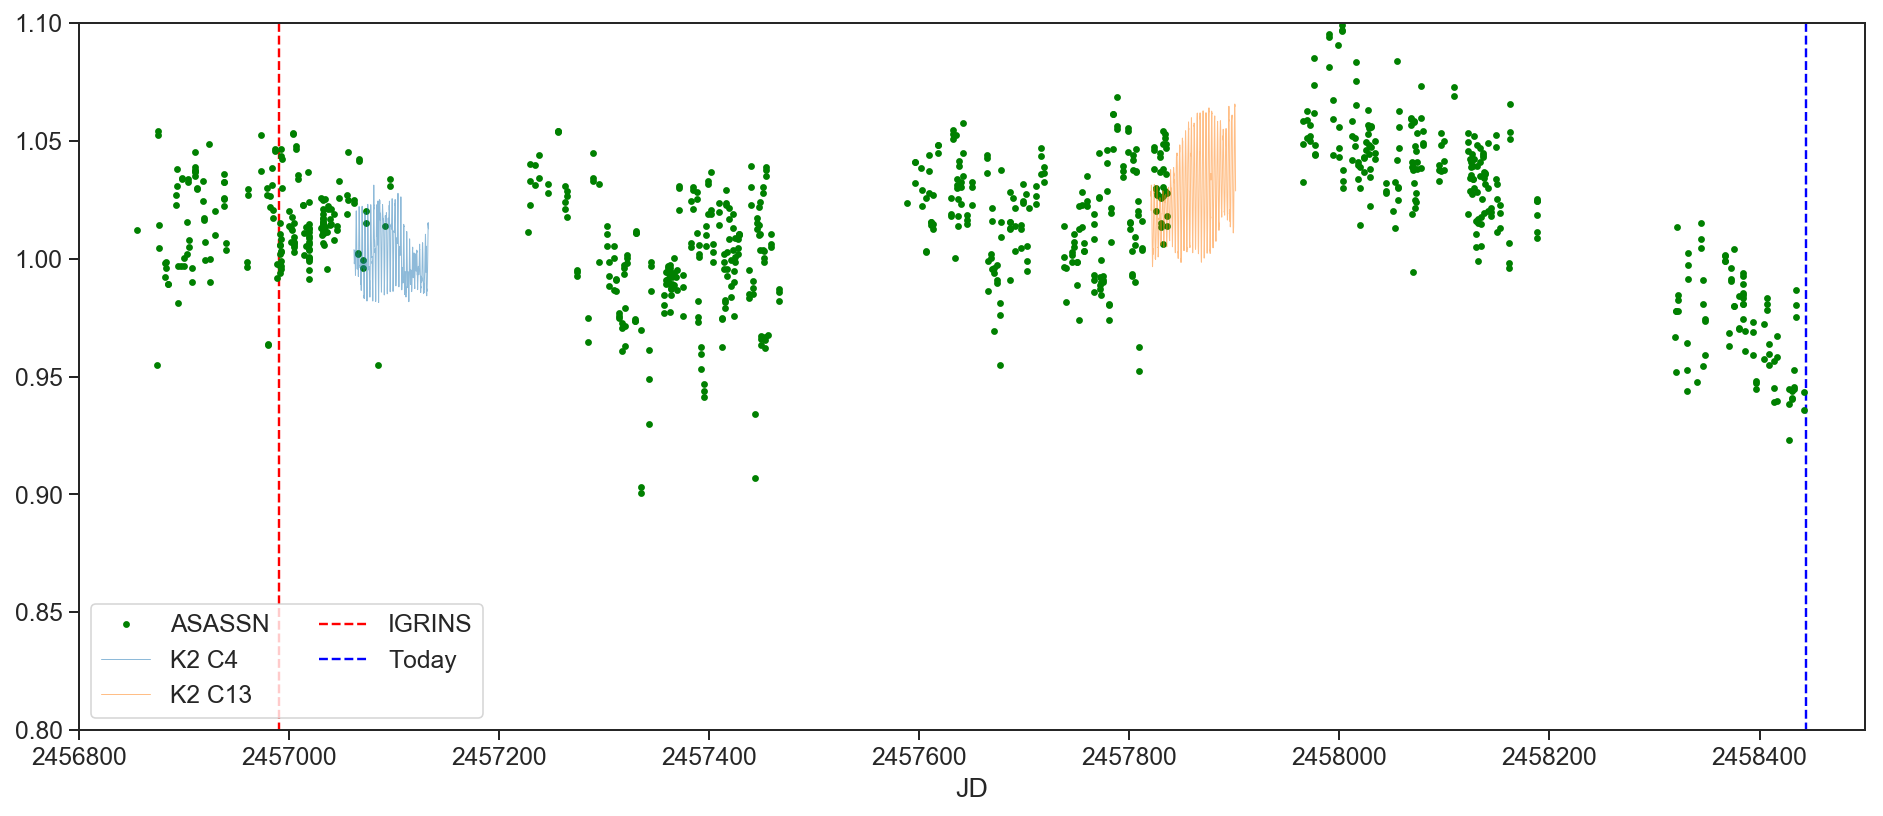

In [198]:
plt.figure(figsize=(16, 6.5))

for source, fmt in zip(sources, fmts):
    inds = master.source == source
    flux = 10**(-master.Vmag[inds]/2.5)
    flux_norm = flux/np.nanmedian(flux)
    #plt.plot(master.JD_like[inds], flux_norm, fmt, ms=4,label=source)

plt.plot(df_new.HJD, df_new.norm_flux/1.005, 'g.', label='ASASSN')
    
for i in range(len(epochs)):
    if epochs.Grankin_name[i] == 'TAP 35':
        label = epochs.Instrument[i]
        plt.vlines(epochs.JD_like[i], 0, 2, colors=epochs.color[i], 
                   linestyles='dashed', label = label)


plt.vlines(2458444.37122, 0, 2, colors='blue', linestyles='dashed', label='Today')



k2_jd = lc.time + 2454833.0
plt.plot(k2_jd, lc.normalize().flux-0.00, alpha=0.5, label = 'K2 C4', lw=0.5)
k2_jd2 = lc2.time + 2454833.0
plt.plot(k2_jd2, lc2.normalize().flux+0.026, alpha=0.5, label = 'K2 C13', lw=0.5)

plt.ylim(0.8, 1.1)

#plt.ylabel('$V$')
plt.xlabel('JD')

plt.xlim(2456800,2458500)
legend = plt.legend(loc='bottom middle', ncol=2)#, frameon=True, shadow=False, )
plt.savefig('../results/TAP35_demo.png', bbox_inches='tight', dpi=300)

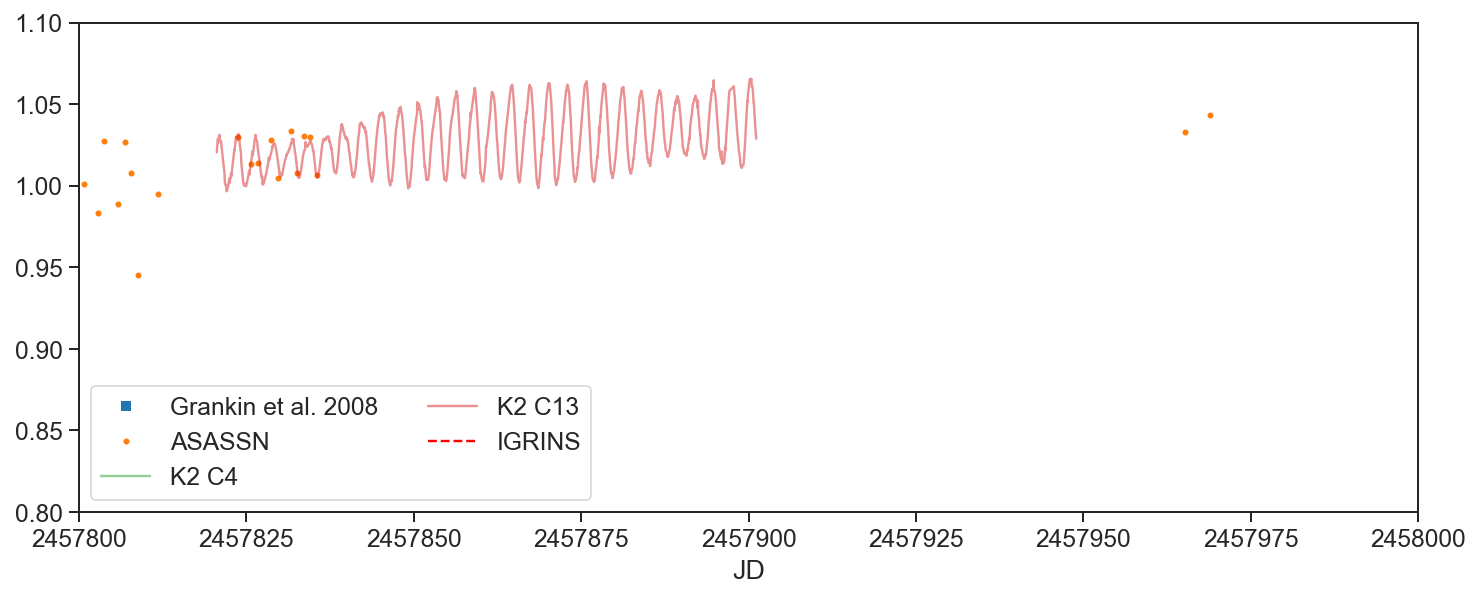

In [162]:
plt.figure(figsize=(12, 4.5))

for source, fmt in zip(sources, fmts):
    inds = master.source == source
    flux = 10**(-master.Vmag[inds]/2.5)
    flux_norm = flux/np.nanmedian(flux)
    plt.plot(master.JD_like[inds], flux_norm, fmt, ms=4,label=source)

for i in range(len(epochs)):
    if epochs.Grankin_name[i] == 'TAP 35':
        label = epochs.Instrument[i]
        plt.vlines(epochs.JD_like[i], 0, 2, colors=epochs.color[i], 
                   linestyles='dashed', label = label)
    
#plt.vlines(2446192.083333, 13.5, 12.2, colors='cyan', linestyles='dashed')



k2_jd = lc.time + 2454833.0
plt.plot(k2_jd, lc.normalize().flux-0.00, alpha=0.5, label = 'K2 C4')
k2_jd2 = lc2.time + 2454833.0
plt.plot(k2_jd2, lc2.normalize().flux+0.026, alpha=0.5, label = 'K2 C13')

plt.ylim(0.8, 1.1)

#plt.ylabel('$V$')
plt.xlabel('JD')

plt.xlim(2457800,2458000)
legend = plt.legend(loc='bottom left', ncol=2)#, frameon=True, shadow=False, )
#plt.savefig('../results/V819_phot1986-2017.pdf', bbox_inches='tight')

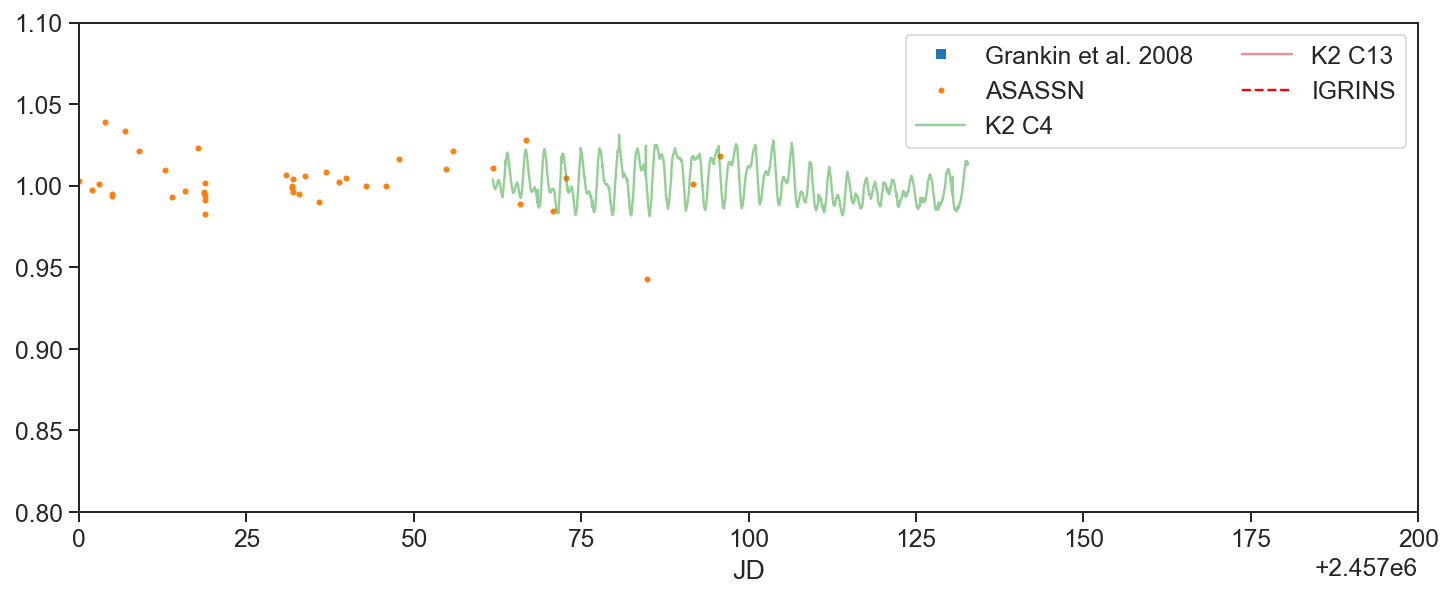

In [163]:
plt.figure(figsize=(12, 4.5))

for source, fmt in zip(sources, fmts):
    inds = master.source == source
    flux = 10**(-master.Vmag[inds]/2.5)
    flux_norm = flux/np.nanmedian(flux)
    plt.plot(master.JD_like[inds], flux_norm, fmt, ms=4,label=source)

for i in range(len(epochs)):
    if epochs.Grankin_name[i] == 'TAP 35':
        label = epochs.Instrument[i]
        plt.vlines(epochs.JD_like[i], 0, 2, colors=epochs.color[i], 
                   linestyles='dashed', label = label)
    
#plt.vlines(2446192.083333, 13.5, 12.2, colors='cyan', linestyles='dashed')



k2_jd = lc.time + 2454833.0
plt.plot(k2_jd, lc.normalize().flux-0.00, alpha=0.5, label = 'K2 C4')
k2_jd2 = lc2.time + 2454833.0
plt.plot(k2_jd2, lc2.normalize().flux+0.026, alpha=0.5, label = 'K2 C13')

plt.ylim(0.8, 1.1)

#plt.ylabel('$V$')
plt.xlabel('JD')

plt.xlim(2457000,2457200)
legend = plt.legend(loc='bottom left', ncol=2)#, frameon=True, shadow=False, )
#plt.savefig('../results/V819_phot1986-2017.pdf', bbox_inches='tight')

## Table of estimated $V$ values at the time of observations

In [58]:
eps = eps[keep]

In [59]:
eps

,JD-2450000,Instrument,B_est,V_est,R_est
0,6980.889063,IGRINS,NaN,10.109653,NaN
1,6981.861100,IGRINS,NaN,10.122732,NaN
2,6982.724769,IGRINS,NaN,10.105819,NaN
3,6982.830000,IGRINS,NaN,10.106327,NaN
4,6984.844769,IGRINS,NaN,10.119399,NaN
5,6987.927338,IGRINS,NaN,10.113537,NaN
6,6989.869491,IGRINS,NaN,10.115553,NaN
7,6990.709491,IGRINS,NaN,10.110163,NaN
8,6990.763368,IGRINS,NaN,10.109648,NaN
9,6990.790382,IGRINS,NaN,10.109467,NaN


In [60]:
latex_fmts = [lambda x:"{:0.4f}".format(x), lambda x:"{}".format(x), 
        lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x)]

In [61]:
tbl_out = eps

In [62]:
print(tbl_out.to_latex(index=False, na_rep='$\cdots$', formatters=latex_fmts))

\begin{tabular}{rlrrr}
\toprule
JD-2450000 & Instrument & B\_est & V\_est & R\_est \\
\midrule
 6980.8891 &     IGRINS &   nan & 10.11 &   nan \\
 6981.8611 &     IGRINS &   nan & 10.12 &   nan \\
 6982.7248 &     IGRINS &   nan & 10.11 &   nan \\
 6982.8300 &     IGRINS &   nan & 10.11 &   nan \\
 6984.8448 &     IGRINS &   nan & 10.12 &   nan \\
 6987.9273 &     IGRINS &   nan & 10.11 &   nan \\
 6989.8695 &     IGRINS &   nan & 10.12 &   nan \\
 6990.7095 &     IGRINS &   nan & 10.11 &   nan \\
 6990.7634 &     IGRINS &   nan & 10.11 &   nan \\
 6990.7904 &     IGRINS &   nan & 10.11 &   nan \\
 6990.8840 &     IGRINS &   nan & 10.11 &   nan \\
 6990.9005 &     IGRINS &   nan & 10.11 &   nan \\
 6990.9226 &     IGRINS &   nan & 10.11 &   nan \\
 6992.6317 &     IGRINS &   nan & 10.11 &   nan \\
 6992.9876 &     IGRINS &   nan & 10.11 &   nan \\
 6997.7589 &     IGRINS &   nan & 10.11 &   nan \\
 6999.8348 &     IGRINS &   nan & 10.11 &   nan \\
 7016.7479 &     IGRINS &   nan & 10.1

<!--NAVIGATION-->
< [Lightcurves](04.00-Lightcurves.ipynb) | [Contents](Index.ipynb) | [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) >